In [1]:
conda install statsmodels

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [13]:
stock_data = pd.read_csv('/Users/ramonrodriguez/Desktop/acgl.us.csv', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,13.583,13.693,13.430,13.693,156240,0
1,2005-02-28,13.697,13.827,13.540,13.827,370509,0
2,2005-03-01,13.780,13.913,13.720,13.760,224484,0
3,2005-03-02,13.717,13.823,13.667,13.810,286431,0
4,2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...,...
3196,2017-11-06,94.490,95.650,94.020,95.550,420192,0
3197,2017-11-07,95.860,95.950,95.200,95.560,464011,0
3198,2017-11-08,95.410,95.900,94.890,95.450,471756,0
3199,2017-11-09,94.930,96.140,94.470,95.910,353498,0


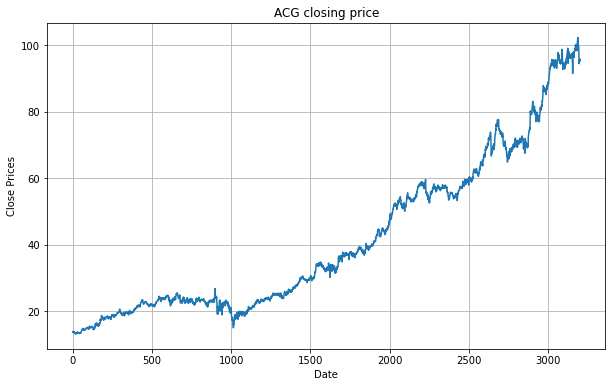

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ACG closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

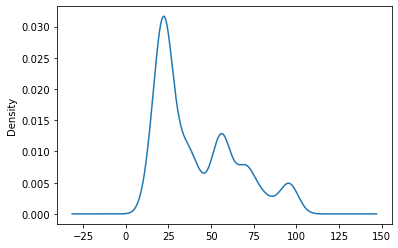

In [28]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

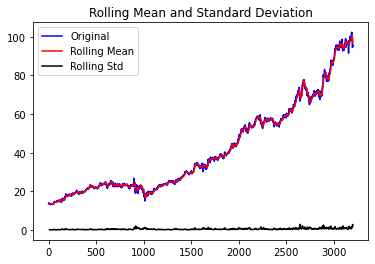

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [29]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

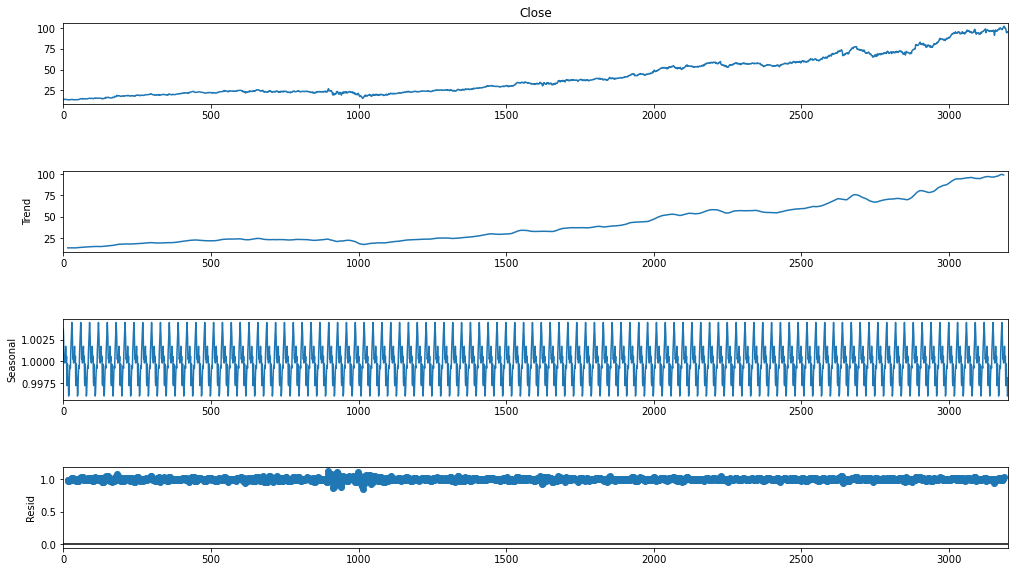

In [34]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


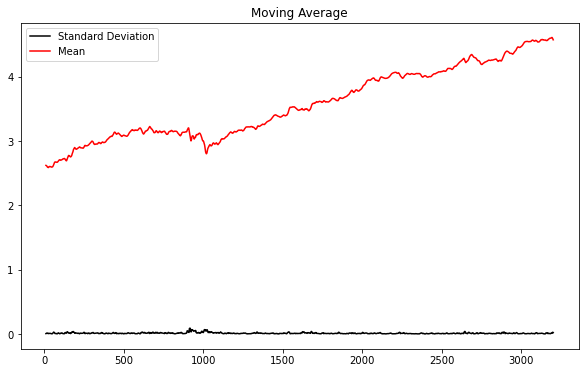

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

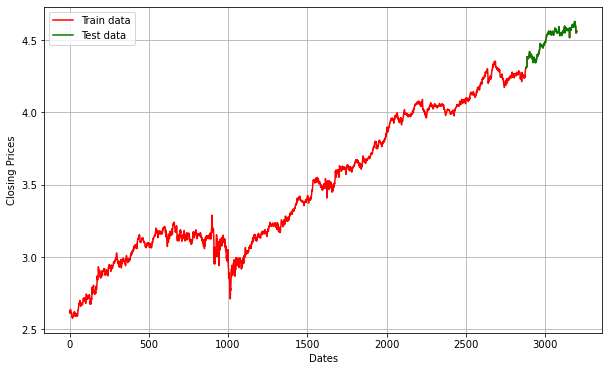

In [37]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'red', label='Train data')
plt.plot(test_data, 'green', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=1.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.33 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 7.464 seconds
   

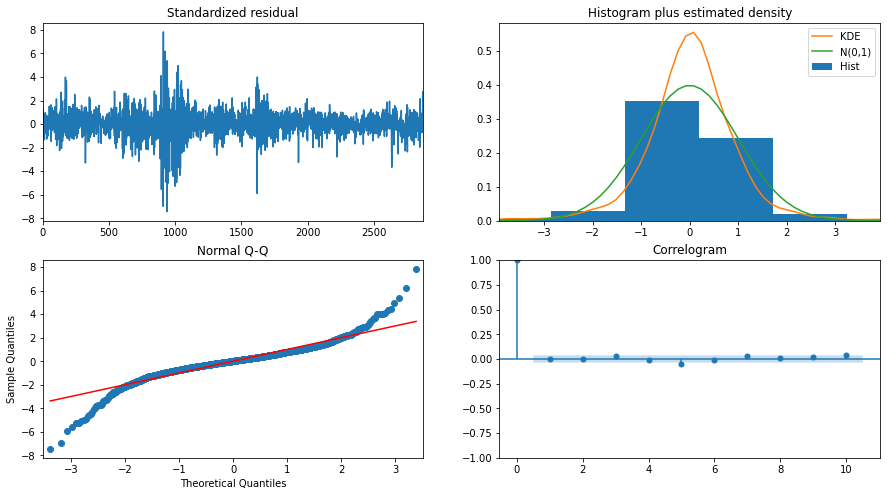

In [38]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [40]:
import statsmodels.api as sm

In [65]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()  
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2877
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8267.798
Date:                Mon, 29 Aug 2022   AIC                         -16527.597
Time:                        00:06:41   BIC                         -16503.740
Sample:                             0   HQIC                        -16518.997
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8973      0.036     24.798      0.000       0.826       0.968
ma.L1         -1.0130      0.039    -25.731      0.000      -1.090      -0.936
ma.L2          0.0826      0.014      5.842      0.0

In [68]:
pip install pandas_datareader

     |████████████████████████████████| 109 kB 5.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


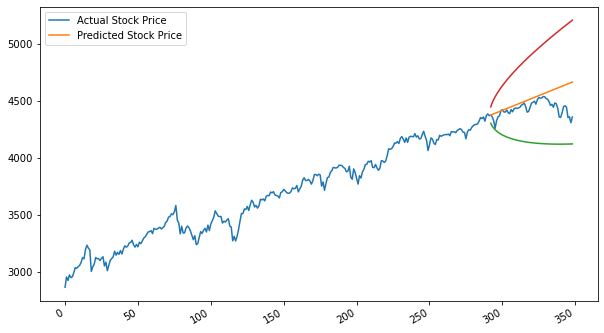

In [69]:
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt

df = web.DataReader('^GSPC', 'yahoo', start='2020-05-15', end='2021-10-01')
total = len(df)
aaa = 57
hist = total - aaa

model = sm.tsa.statespace.SARIMAX(df['Close'].values[:hist], trend='c', order=(0,1,0))
fitted = model.fit(disp=False)

result = fitted.forecast(aaa, alpha =0.05)
conf_ins = fitted.get_forecast(aaa).summary_frame()
ind = np.arange(total)

fig, ax = plt.subplots()
ax.plot(ind, df['Close'].values, label='Actual Stock Price')
ax.plot(ind[hist:], result,label='Predicted Stock Price')
ax.plot(ind[hist:], conf_ins['mean_ci_lower'])
ax.plot(ind[hist:], conf_ins['mean_ci_upper'])
ax.legend()
fig.autofmt_xdate()
plt.show()

In [70]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.050471640464643384
MAE: 0.20771790114422578
RMSE: 0.22465894254323238
MAPE: 0.045788562477021795


In [58]:
fc= fitted.forecast(321, alpha=0.05)  # 95% conf
